# Spark Approach

## Integrating everything as a spark DataFrame

In [ ]:
# import pyspark as ps
# spark = (ps.sql.SparkSession.builder 
#         .master("local[4]") 
#         .appName("sparkSQL exercise")
#         .config("spark.sql.caseSensitive", "true")
#         .getOrCreate()
#         )
# sc = spark.sparkContext

# peer = spark.read.json('new.json')

# peer.printSchema()

# peer.createOrReplaceTempView("peer")

# result = spark.sql("""SELECT lang, COUNT(lang)
#             FROM peer 
#             GROUP BY lang
#             """)

# result.show()

# Manual Approach using Open and Json

In [1]:
import json
from tqdm import tqdm # google this
journals = []
idx = 0

with open('dblpv13.json',"r") as fp:
     for line in tqdm(fp):
        if idx > 100000: 
            break
        try:
            if len(line) < 3:
                continue
            strip_line = line.strip(',')
            journals.append(json.loads(strip_line))
            idx += 1
        except:
            print('fail')
            try:
                strip_line = line.strip(',')
                journals.append(json.loads(strip_line))
                idx += 1
            except:
                idx += 1
                pass

100002it [00:03, 25268.30it/s]


## Converting Import to Pandas and Defining Methods to Use

In [2]:
import pandas as pd
journal_df = pd.DataFrame(journals, columns = journals[0].keys())

In [1069]:
def plot_counters(count_set,ax, num = 20, title = 'Frequency of Keywords', rotation = 0, **kwargs):
    '''
    Helps plot bar plots using the count_set as input. 
    num is number of most common in counter
    **kwargs are similar to plt.bar(**kwargs)
    '''
    try:
        assert(type(count_set) == type(Counter()))
        
        
        labels, values = zip(*count_set.most_common(num))
        indexes = np.arange(len(labels))
        ax.bar(indexes, values, **kwargs)
        ax.set_title(title)
#         ax.set_xticks(indexes + 0.5, labels, rotation = 90)
        ax.set_xticks(indexes)
        ax.set_xticklabels(labels, rotation = rotation)
    except Exception as e:
        print(e, "Assertion Error! Needs counter for input")

In [848]:
def check_column(column):
    try:
        assert(type(column) == pd.Series)
        assert(len(column) == column.shape[0])
    except AssertionError:
        print('Incorrect Type of Input')

def counter_column(column, key = None, last = False, err = False):
    '''
     Identifies most common attributes of a given Series. Faster Counter
     dict_ refers to if subquery is dictionary. False is for list
     key = specific key in dictionary (assuming dict_ is true)
     last = identify first or last item in list
     err = return error counter
    '''
    from tqdm import tqdm 
    
    check_column(column)
    count_items = Counter()
    errors = Counter()
    idx = 0
    for items in tqdm(column):
#         if idx > 500: #Limit breaks if required for debugging
#             break
        try:
            if len(items) == 0:
                    idx += 1
                    continue
            if (key is not None) and (type(items) == dict):
                if (len(items) == 1):
                    if count_items.get(items[key]) is None:
                        count_items[items[key]] = 1
                    else:
                        count_items[items[key]] += 1
                    idx += 1
                else:
                    if count_items.get(items[key]) is None:
                        count_items[items[key]] = 1
                    else:
                        count_items[items[key]] += 1
                    idx += 1
            elif (key is not None):
                if (len(items) == 1):
                    if count_items.get(items[-last][key]) is None:
                        count_items[items[-last][key]] = 1
                    else:
                        count_items[items[-last][key]] += 1
                    idx += 1
                else:
                    if count_items.get(items[-last][key]) is None:
                        count_items[items[-last][key]] = 1
                    else:
                        count_items[items[-last][key]] += 1
                    idx += 1
            elif type(items) == list:    
                if len(items) == 1:
                    if count_items.get(items[-last]) is None:
                        count_items[items[-last]] = 1
                    else:
                        count_items[items[-last]] += 1
                    idx += 1
                else:
                    if count_items.get(items[-last]) is None:
                        count_items[items[-last]] = 1
                    else:
                        count_items[items[-last]] += 1
            else:    
                if len(items) == 1:
                    if count_items.get(items) is None:
                        count_items[items] = 1
                    else:
                        count_items[items] += 1
                    idx += 1
                else:
                    if count_items.get(items) is None:
                        count_items[items] = 1
                    else:
                        count_items[items] += 1
                    idx += 1
        except Exception as e:
            e = str(e)
            if errors.get(e) is None:
                errors[e] = 1
            else:
                errors[e] += 1
#             print("error ", e ,idx)
            idx+=1
            pass
    if err:
        return count_items, errors
    return count_items

In [376]:
def df_reindex(df, series):
    '''
    Verifies column is an appropriate series
    
    Reindexes series to fit existing dataframe index with no loss.
    
    Goes up to index only - use with identical sized dataframe and pandas series
    '''
    check_column(series)
    try:
        assert(len(df) == len(series))
        index_df = pd.DataFrame(df.index, index = np.arange(len(df.index)), columns = ['index'])
        index_df['new'] = series
        index_df = index_df.set_index('index')
        return index_df
    except:
        print("Assertion Error! Different sized dataframe or column")
        pass
    
    
    

In [652]:
def add_column(df, orig_col, new_col, key = None, last = False):
    '''
     Extracts Information from internal dictionaries or lists contained in DataFrame original column
     Adds as new column to original df
     Returns error counter with number of errors encountered.
     
     key = specific key in dictionary (assuming line is dictionary - will return emtpy list otherwise)
     last = identify first or last item in list
    '''
    from tqdm import tqdm
    temp_df = pd.Series(np.nan, index = np.arange(len(df.index)))
    errors = Counter()
    idx = 0
    for items in tqdm(df[orig_col]):
        try:
            if len(items) == 0:
                    idx += 1
                    continue
            if (key is not None) and (type(items) == dict):
                if (len(items) == 1):
                    temp_df.loc[idx] = items[key]
                    idx += 1
                else:
                    temp_df.loc[idx] = items[key]
                    idx += 1
            elif (key is not None):
                if (len(items) == 1):
                    temp_df.loc[idx] = items[-last][key]
                    idx += 1
                else:
                    temp_df.loc[idx] = items[-last][key]
                    idx += 1
            else:    
                if (len(items) == 1):
                    temp_df.loc[idx] = items[-last]
                    idx += 1
                else:
                    temp_df.loc[idx] = items[-last]
                    idx += 1
               
        except Exception as e:
            e = str(e)
            if errors.get(e) is None:
                errors[e] = 1
            else:
                errors[e] += 1
#             print("error at ", idx, ". ", e)
            idx+=1
            pass
    
    temp_df = df_reindex(df, temp_df)
    df[new_col] = temp_df
    del temp_df
    
    return errors
    

# Extracting All Information From Dataframe

In [645]:
#Counting the number of keywords, authors, urls, etc 
journal_df['n_keywords'] = journal_df.keywords.str.len()
journal_df['abstract_length'] = journal_df.abstract.str.len()
journal_df['n_authors'] = journal_df.authors.str.len()
journal_df['n_url'] = journal_df.url.str.len()

In [657]:
add_column(journal_df, 'authors', 'last_author', key = 'name', last = True)
add_column(journal_df, 'authors', 'first_author', key = 'name')
add_column(journal_df, 'venue', 'venue_name', key = 'raw')
add_column(journal_df, 'keywords', 'first_keyword')

100%|██████████| 100001/100001 [00:03<00:00, 26637.94it/s]


Counter({"object of type 'float' has no len()": 52})

# Analyzing the Data

## Questions to Answer:

### General Data
* Amount of journal releases over the number of years
* How much has no or negligible citations (i.e. junk journals)?
    * This would assume either 0 citations and/or no author
    * What percentage is this of total?
* Of the junk citations - who are the worst offenders?
    * Look at Authors and Venues
    * Do they have a common area or tend to use a specific keyword?
    * Limit to top 10

###  Focused Data  
* Limit the citations to be something considered influential. 10 or more citations is considered to be solid.
    * Check the distribution of citations. It should be heavily focused to one-side
* What are the top ten venues, authors and keywords?
* Of the Top 10 everything - what is the distribution of citations for each?
* Is there a difference between the #1 and #10 source? What about #5 and #10?
    * Repeat for each venue, authors, keywords
* Is there a statistically significant difference between the #1 venue and #1 author?
    

# General Data

**Question 1** - Amount of journal releases over the number of years

In [661]:
#Isolates to releases that occur during 1500 through 2021 (current year) - unknown year otherwise.
releases_year = journal_df[['year', '_id']].groupby('year').count().reset_index()
releases_year = releases_year[(releases_year['year'] > 1500) & (releases_year['year'] < 2022)]

Text(0, 0.5, 'Frequency')

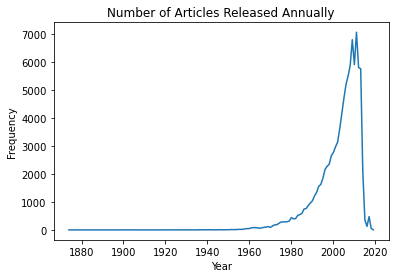

In [662]:
import matplotlib.pyplot as plt

plt.plot(releases_year.iloc[:, 0], releases_year.iloc[:,1])
plt.title("Number of Articles Released Annually")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.savefig('img/annual_article_release.png')

Text(0, 0.5, 'Frequency')

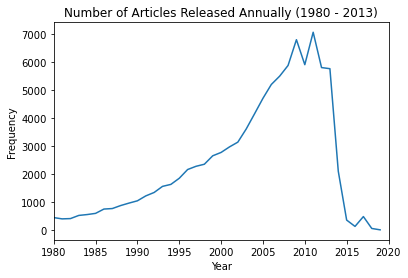

In [663]:
plt.plot(releases_year.iloc[:, 0], releases_year.iloc[:,1])
plt.title("Number of Articles Released Annually (1980 - 2013)")
plt.xlim(1980, 2020)
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.savefig('img/annual_article_release_1980-2013.png')

**Question 2**
* How much has no or negligible citations (i.e. junk journals)?
    * This would assume either 0 citations and/or no author
* What percentage is this of total?

In [671]:
#Out of 99967 entries - where year provided was between 1500 and 2020 (0.03% removal)
#73044 had 1 or more citations. ~ 73% had been cited more than once.
#0.8% of those entries had been cited more than 1000 times

filter_journal = journal_df[(journal_df['year'] > 1500) & (journal_df['year'] < 2022)]
filter_journal_citations =  filter_journal[(filter_journal['n_citation'] > 0) & (filter_journal['n_authors'] > 0)]
keywords = len(filter_journal_citations[filter_journal_citations.n_keywords > 0])
venues = len(filter_journal_citations[filter_journal_citations.n_keywords > 0])

total = len(journal_df)
year_minus = len(filter_journal)
cit_1 = len(filter_journal_citations)

print(f'''There are {total} total entries. Of those, {year_minus} where release year was noted between 1500 and 2020. ({round((total - year_minus)/total * 100, 2)}% removal) 
Of those {cit_1} had 1 or more citations and an author. ~ {round(cit_1/year_minus*100,1)}% had been cited more than once. ({round((year_minus - cit_1)/year_minus * 100, 2)}% removal)
There are {round(keywords,2)} journals with keywords notated, roughly {round((cit_1 - keywords)/cit_1 * 100,2)}% have no keywords''')

There are 100001 total entries. Of those, 99967 where release year was noted between 1500 and 2020. (0.03% removal) 
Of those 72738 had 1 or more citations and an author. ~ 72.8% had been cited more than once. (27.24% removal)
There are 56789 journals with keywords notated, roughly 21.93% have no keywords


**Question 3**

* Of the junk citations - who are the worst offenders?
    * Look at Authors and Venues
    * Do they have a common area or tend to use a specific keyword?
* Limit to top 10

In [714]:
junk_citations = filter_journal[(filter_journal['n_citation'] == 0) | (filter_journal['n_authors'] == 0)]

first_name_all = counter_column(junk_citations['authors'], key = 'name')
last_name_all = counter_column(junk_citations['authors'], key = 'name', last = True)
venue_all = counter_column(junk_citations['venue'], key = 'raw')
keywords_all = counter_column(junk_citations['keywords'])

100%|██████████| 25307/25307 [00:00<00:00, 665028.83it/s]


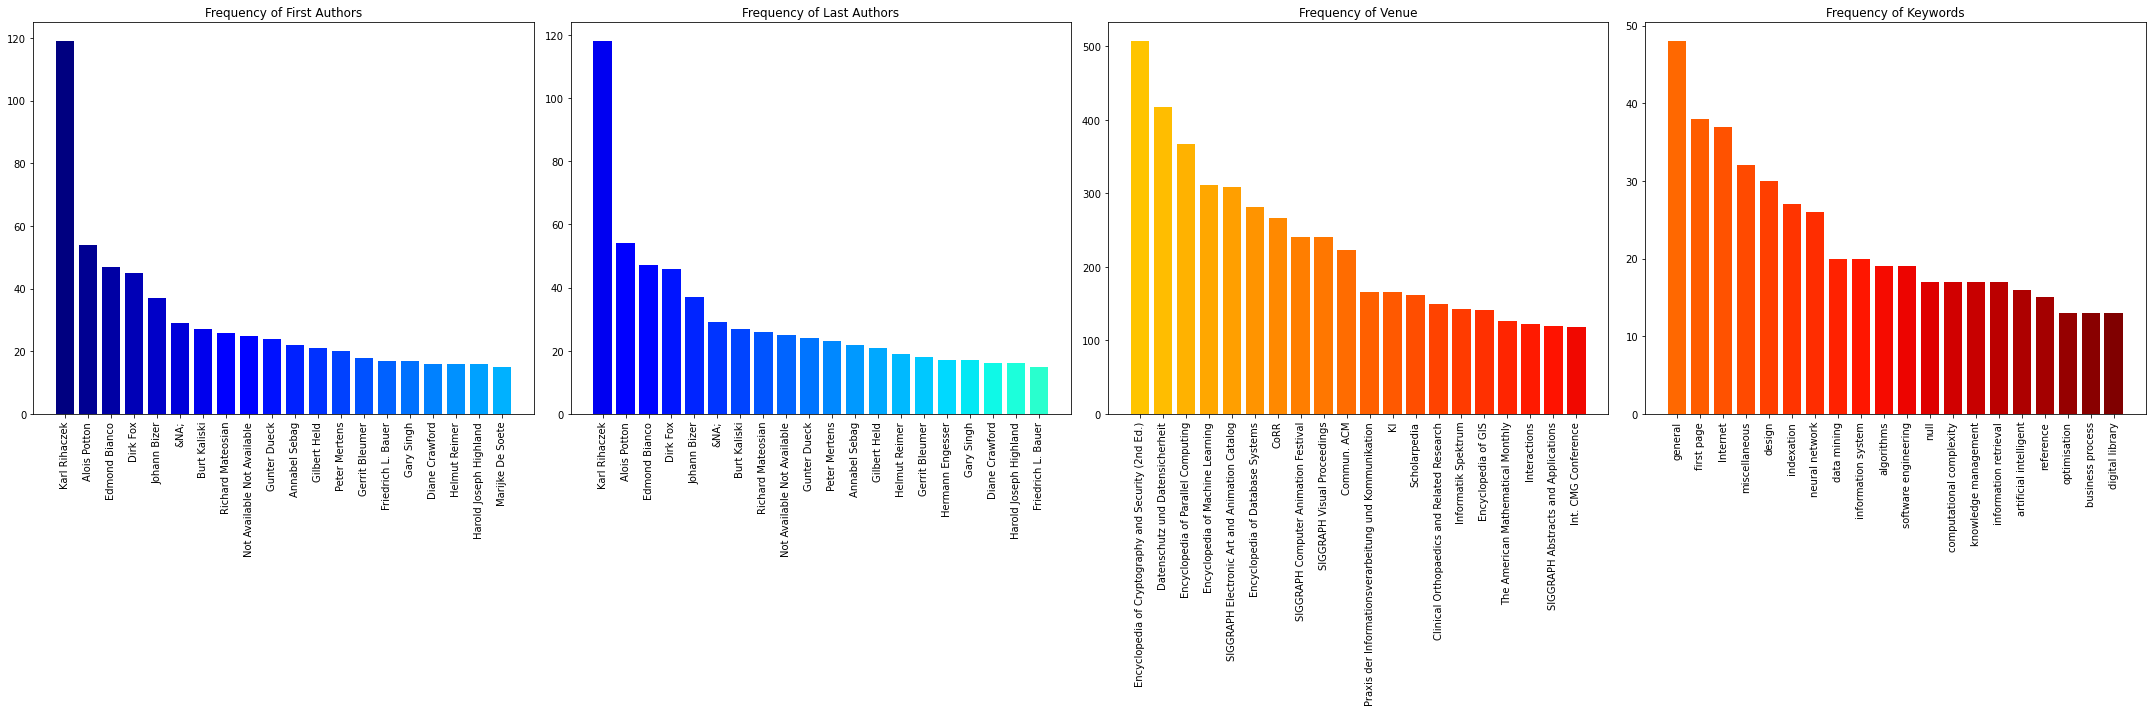

In [1082]:
fig, axs = plt.subplots(ncols = 4, figsize = (30, 10))
lst = [(first_name_all, 'Frequency of First Authors', plt.cm.jet(np.linspace(0.0,.3,20))),
       (last_name_all, 'Frequency of Last Authors', plt.cm.jet(np.linspace(0.1,.4,20))), 
       (venue_all, 'Frequency of Venue', plt.cm.jet(np.linspace(0.7,.9,20))), 
      (keywords_all, 'Frequency of Keywords', plt.cm.jet(np.linspace(0.8,1,20)))]

for idx, ax in enumerate(axs.flatten()):
    plot_counters(lst[idx][0], ax, num = 20, title = lst[idx][1], rotation = 90, color = lst[idx][2])

plt.tight_layout()
plt.savefig('img/Frequency_Layouts.png')

In [748]:
first_name_all.most_common(10), last_name_all.most_common(12)

([('Karl Rihaczek', 119),
  ('Alois Potton', 54),
  ('Edmond Bianco', 47),
  ('Dirk Fox', 45),
  ('Johann Bizer', 37),
  ('&NA;', 29),
  ('Burt Kaliski', 27),
  ('Richard Mateosian', 26),
  ('Not Available Not Available', 25),
  ('Gunter Dueck', 24)],
 [('Karl Rihaczek', 118),
  ('Alois Potton', 54),
  ('Edmond Bianco', 47),
  ('Dirk Fox', 46),
  ('Johann Bizer', 37),
  ('&NA;', 29),
  ('Burt Kaliski', 27),
  ('Richard Mateosian', 26),
  ('Not Available Not Available', 25),
  ('Gunter Dueck', 24),
  ('Peter Mertens', 23),
  ('Annabel Sebag', 22)])

In [768]:
names, value = zip(*last_name_all.most_common(12))

lst = []
remove_lst = ['&NA;', 'Not Available Not Available', 'null']
name = [name for name in names if name not in remove_lst]
junk_citations[junk_citations['last_author'].isin(name)].groupby(['last_author', 'venue_name']).agg(['count','mean', 'std'])


year  \
                                                                     count   
last_author       venue_name                                                 
Alois Potton      Praxis der Informationsverarbeitung und Kommuni...    54   
Annabel Sebag     ACM SIGGRAPH 2011 Computer Animation Festival          1   
                  ACM SIGGRAPH 2012 Computer Animation Festival          1   
                  SIGGRAPH ASIA Computer Animation Festival              2   
                  SIGGRAPH Computer Animation Fesitval                   3   
                  SIGGRAPH Computer Animation Festival                  13   
                  Scholarpedia                                           1   
Burt Kaliski      Encyclopedia of Cryptography and Security (2nd ...    27   
Dirk Fox          Datenschutz und Datensicherheit                       46   
Edmond Bianco     BIAA                                                  47   
Gunter Dueck      HMD - Praxis Wirtschaftsinform.                        1   
                  Informatik Spektrum                                   23   
Johann Bizer      Datenschutz und Datensicherheit                       37   
Karl Rihaczek     Datenschutz Und Datensicherheit - Dud                  1   
                  Datenschutz und Datensicherheit                      116   
                  GI-Jahrestagung                                        1   
Peter Mertens     Informatik Spektrum                                    1   
                  Praxis der Informationsverarbeitung und Kommuni...     1   
                  Wirtschaftsinformatik                                 21   
Richard Mateosian COMPCON                                                1   
                  IEEE Micro                                            23   
                  Micro, IEEE                                            1   
                  Nature Reviews Molecular Cell Biology                  1   

                                                                                   \
                                                                             mean   
last_author       venue_name                                                        
Alois Potton      Praxis der Informationsverarbeitung und Kommuni...  2001.962963   
Annabel Sebag     ACM SIGGRAPH 2011 Computer Animation Festival       2011.000000   
                  ACM SIGGRAPH 2012 Computer Animation Festival       2012.000000   
                  SIGGRAPH ASIA Computer Animation Festival           2013.000000   
                  SIGGRAPH Computer Animation Fesitval                2009.000000   
                  SIGGRAPH Computer Animation Festival                1997.076923   
                  Scholarpedia                                        2009.000000   
Burt Kaliski      Encyclopedia of Cryptography and Security (2nd ...  2010.555556   
Dirk Fox          Datenschutz und Datensicherheit                     2006.739130   
Edmond Bianco     BIAA                                                1994.382979   
Gunter Dueck      HMD - Praxis Wirtschaftsinform.                     2003.000000   
                  Informatik Spektrum                                 2007.260870   
Johann Bizer      Datenschutz und Datensicherheit                     2004.243243   
Karl Rihaczek     Datenschutz Und Datensicherheit - Dud               2010.000000   
                  Datenschutz und Datensicherheit                     2006.284483   
                  GI-Jahrestagung                                     1988.000000   
Peter Mertens     Informatik Spektrum                                 1979.000000   
                  Praxis der Informationsverarbeitung und Kommuni...  1981.000000   
                  Wirtschaftsinformatik                               1996.952381   
Richard Mateosian COMPCON                                             1984.000000   
                  IEEE Micro                                          2005.260870   
 

array([[<AxesSubplot:xlabel='year', ylabel='year'>,
        <AxesSubplot:xlabel='n_citation', ylabel='year'>,
        <AxesSubplot:xlabel='n_keywords', ylabel='year'>,
        <AxesSubplot:xlabel='abstract_length', ylabel='year'>,
        <AxesSubplot:xlabel='n_authors', ylabel='year'>,
        <AxesSubplot:xlabel='n_url', ylabel='year'>],
       [<AxesSubplot:xlabel='year', ylabel='n_citation'>,
        <AxesSubplot:xlabel='n_citation', ylabel='n_citation'>,
        <AxesSubplot:xlabel='n_keywords', ylabel='n_citation'>,
        <AxesSubplot:xlabel='abstract_length', ylabel='n_citation'>,
        <AxesSubplot:xlabel='n_authors', ylabel='n_citation'>,
        <AxesSubplot:xlabel='n_url', ylabel='n_citation'>],
       [<AxesSubplot:xlabel='year', ylabel='n_keywords'>,
        <AxesSubplot:xlabel='n_citation', ylabel='n_keywords'>,
        <AxesSubplot:xlabel='n_keywords', ylabel='n_keywords'>,
        <AxesSubplot:xlabel='abstract_length', ylabel='n_keywords'>,
        <AxesSubplot:xlab

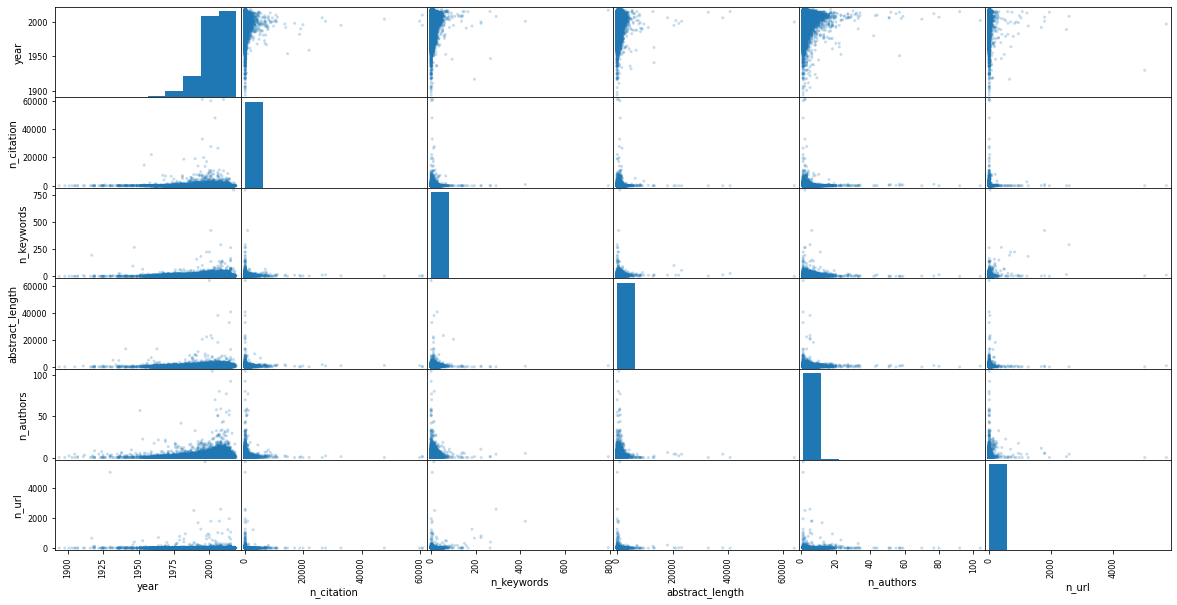

In [767]:
pd.plotting.scatter_matrix(filter_journal_citations, alpha = 0.25, figsize = (20, 10))

In [828]:
#Percentage of Submissions to Encyclopedias in Junk
encyclopedia_lst = [key for key in venue_all.keys() if 'Encyclopedia' in key]
print(round(sum(venue_all.get(entries) for entries in encyclopedia_lst)/ sum(venue_all.values())* 100,2), '% of all 0 citations are in Encyclopedias')

7.77 % of all 0 citations are in Encyclopedias


## Insights from 'Junk Citations'

* Praxis der Informationsverarbeitung und Kommunikation ceased running in 2016 - means Information processing and communication practice
* SIGGRAPH Computer Animation Festival is a festival - more URL links
* Datenschutz und Datensicherheit - Data Protection and Data Safety


* Almost submissions are all only one author with 0 - negligble keywords tend to get 0 citations though some of the venues are high performing
* Most authors submitted to one journal/ group - if submit to other areas, its only a one off.
* Encyclopedias themselves get cited, but not necessarily the individual contributor


###  Focused Data  
* Limit the citations to be something considered influential. 10 or more citations is considered to be solid.
    * Check the distribution of citations. It should be heavily focused to one-side
* What are the top ten venues, authors and keywords?
* Of the Top 10 everything - what is the distribution of citations for each?
* Is there a difference between the #1 and #10 source? What about #5 and #10?
    * Repeat for each venue, authors, keywords
* Is there a statistically significant difference between the #1 venue and #1 author?

In [918]:
focused_journal =  filter_journal[(filter_journal['n_citation'] >= 10) & (filter_journal['n_authors'] > 0)]

In [919]:
# focused_journal
focused_first = counter_column(focused_journal['authors'], key = 'name')
focused_last = counter_column(focused_journal['authors'], key = 'name', last = True)
focused_venue = counter_column(focused_journal['venue'], key = 'raw')
focused_keyword = counter_column(focused_journal['keywords'])

100%|██████████| 39521/39521 [00:00<00:00, 547472.21it/s]


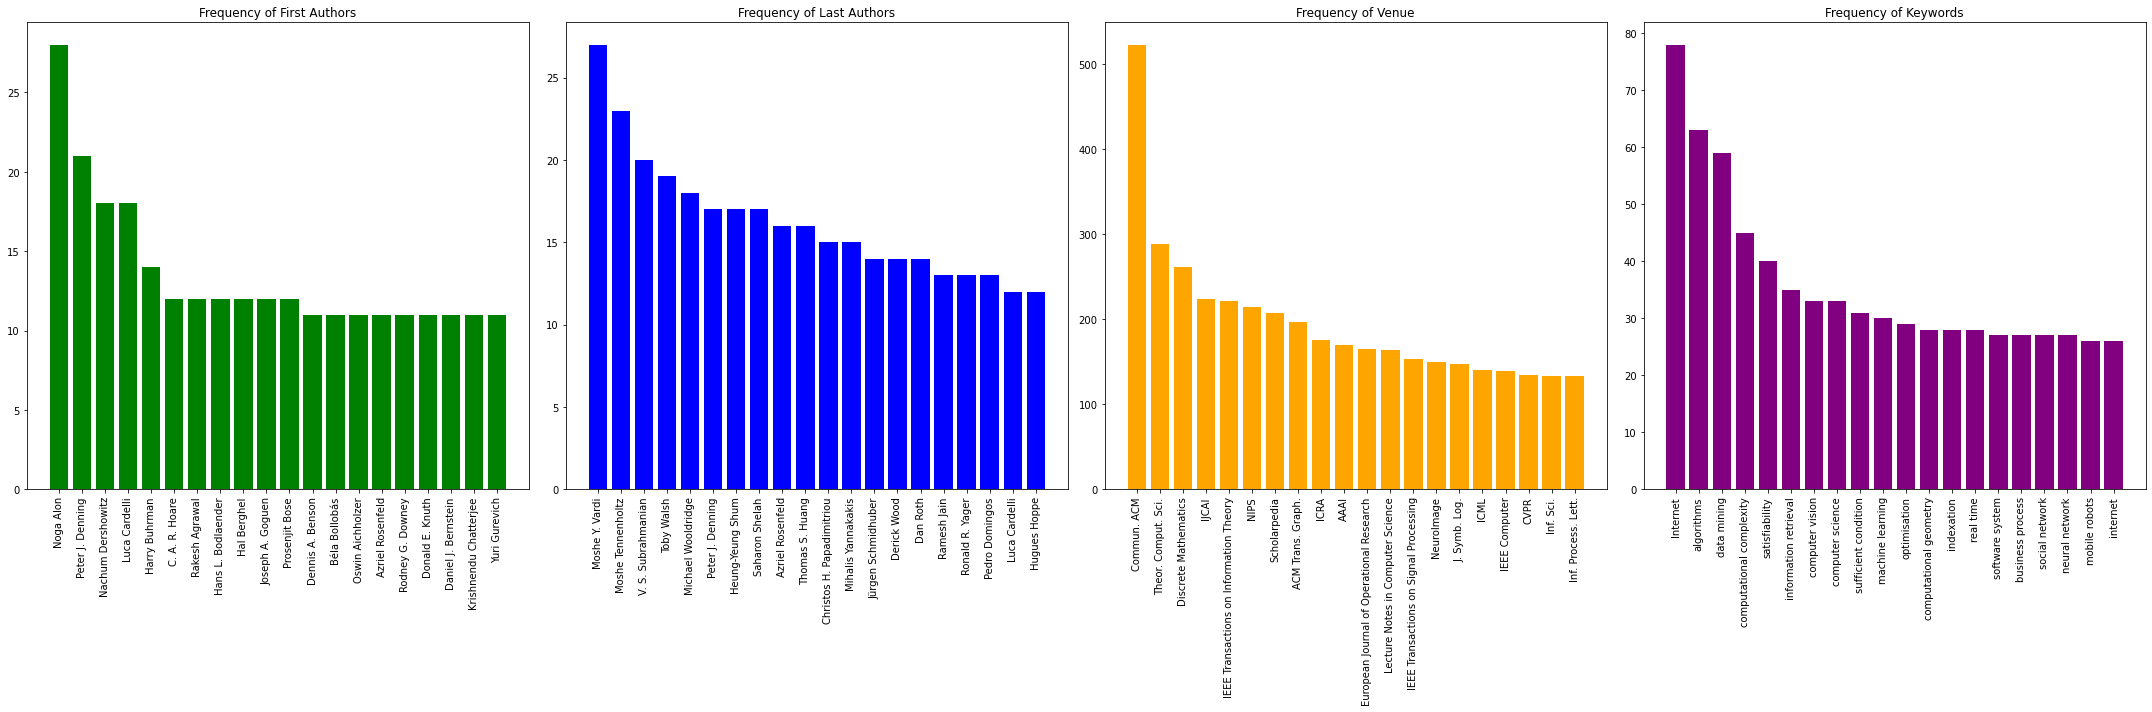

In [920]:
fig, axs = plt.subplots(4, figsize = (30, 10))
lst = [(focused_first, 'Frequency of First Authors', 'green'),
       (focused_last, 'Frequency of Last Authors', 'blue'), 
       (focused_venue, 'Frequency of Venue', 'orange'), 
      (focused_keyword, 'Frequency of Keywords', 'purple')]

for idx, ax in enumerate(axs.flatten()):
    plot_counters(lst[idx][0], ax, num = 20, title = lst[idx][1], color = lst[idx][2])

plt.tight_layout()
plt.savefig('img/Focused_Frequency_Layouts.png')

### Question

**What are the top ten venues, authors and keywords?**

In [921]:
last_keys, last_values = zip(*focused_last.most_common(10))
venue_keys, venue_values = zip(*focused_venue.most_common(10))
keyword_keys, keyword_values = zip(*focused_keyword.most_common(10))

print(f'Top 10\n\nLast Authors:\n{last_keys}\n\nVenues:\n{venue_keys}\n\nKeywords:\n{keyword_keys}')

Top 10

Last Authors:
('Moshe Y. Vardi', 'Moshe Tennenholtz', 'V. S. Subrahmanian', 'Toby Walsh', 'Michael Wooldridge', 'Peter J. Denning', 'Heung-Yeung Shum', 'Saharon Shelah', 'Azriel Rosenfeld', 'Thomas S. Huang')

Venues:
('Commun. ACM', 'Theor. Comput. Sci.', 'Discrete Mathematics', 'IJCAI', 'IEEE Transactions on Information Theory', 'NIPS', 'Scholarpedia', 'ACM Trans. Graph.', 'ICRA', 'AAAI')

Keywords:
('Internet', 'algorithms', 'data mining', 'computational complexity', 'satisfiability', 'information retrieval', 'computer vision', 'computer science', 'sufficient condition', 'machine learning')


### Question

**Of the Top 10 everything - what is the distribution of citations for each?**

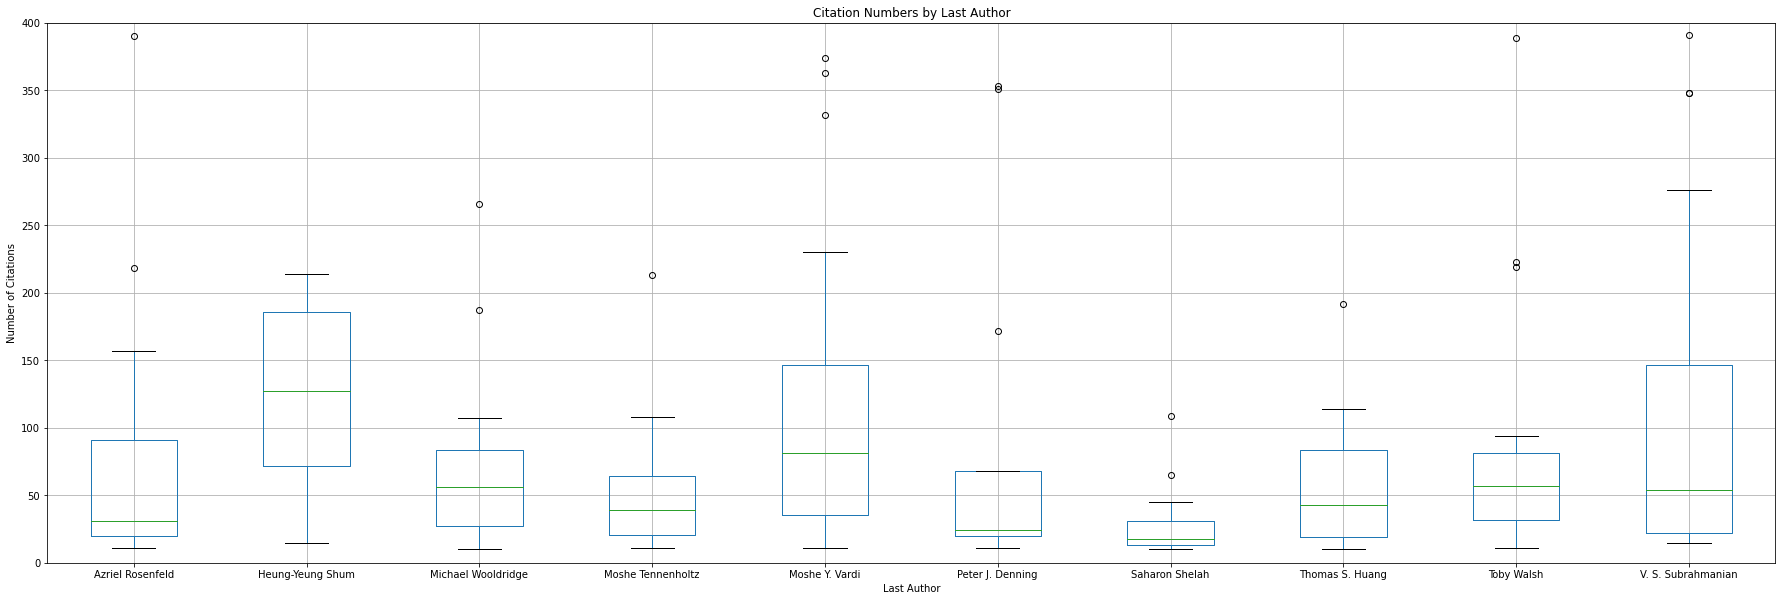

In [922]:
last_author = focused_journal[focused_journal['last_author'].isin(last_keys)][['last_author', 'n_citation']]#.groupby('last_author').boxplot(column = 'n_citation', by = 'last_author',figsize = (30,6))
last_author.boxplot(by = last_author.columns[0], figsize = (30, 10))
plt.ylim(0,400)
plt.xlabel("Last Author")
plt.ylabel("Number of Citations")
plt.title('Citation Numbers by Last Author')
plt.suptitle('')
plt.savefig('img/Last_author_boxplot')

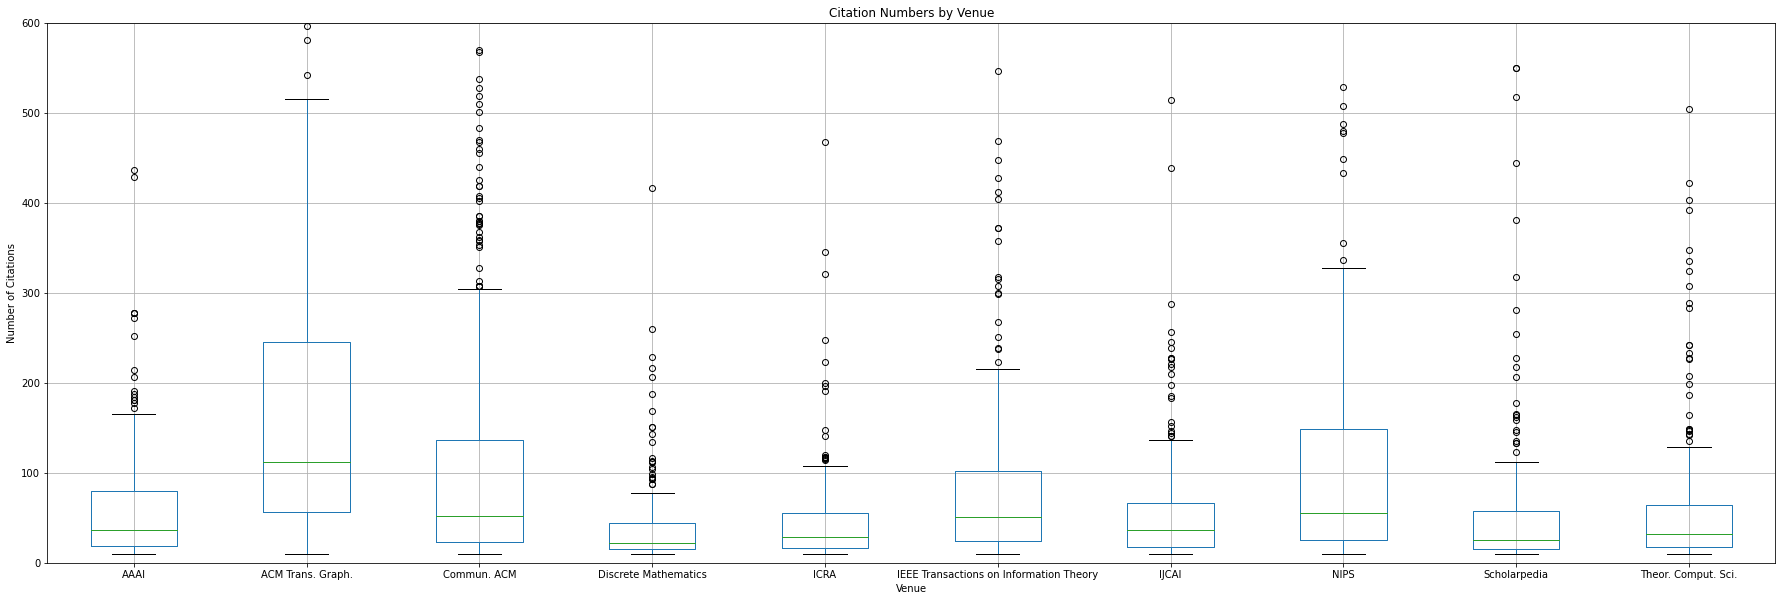

In [923]:
venue = focused_journal[focused_journal['venue_name'].isin(venue_keys)][['venue_name', 'n_citation']]
venue.boxplot(by = venue.columns[0], figsize = (30, 10))
plt.ylim(0,600)
plt.xlabel("Venue")
plt.ylabel("Number of Citations")
plt.title('Citation Numbers by Venue')
plt.suptitle('')
plt.savefig('img/Venue_boxplot')

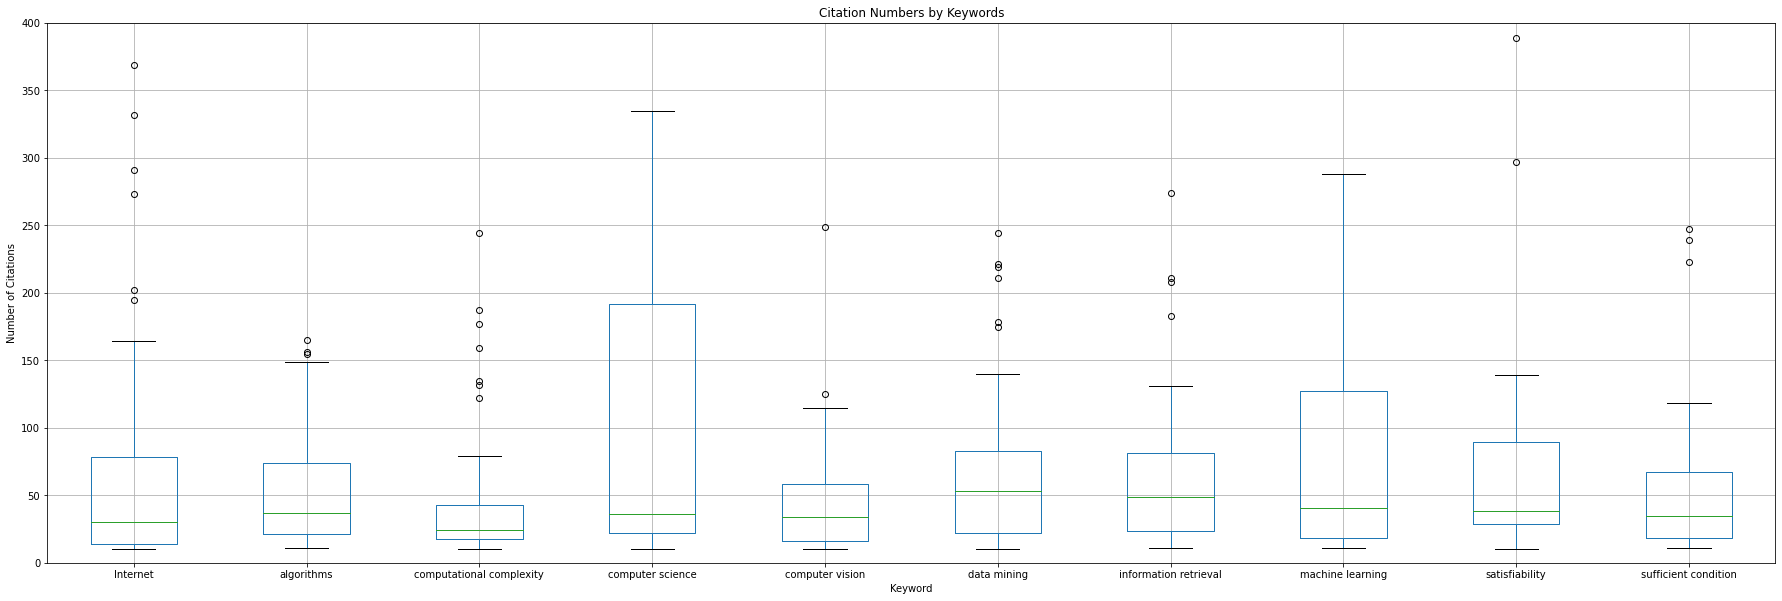

In [924]:
keywords = focused_journal[focused_journal['first_keyword'].isin(keyword_keys)][['first_keyword', 'n_citation']]
keywords.boxplot(by = keywords.columns[0], figsize = (30, 10))
plt.ylim(0,400)
plt.xlabel("Keyword")
plt.ylabel("Number of Citations")
plt.title('Citation Numbers by Keywords')
plt.suptitle('')
plt.savefig('img/keywords_boxplot')

### Question

**Plot the p-value distribution across the within each subset**

Repeat for each venue, authors, keywords

Does the frequency of submissions help or no?


### Null Hypothesis: There is no difference between all the most prolific Authors, Venues or Keywords

### Alternate Hypothesis: There is an intergroup difference between the Authors, Venues or Keywords. 

#### Note: Each Hypothesis is independent of one another

##### Alpha = 0.05

In [1015]:
import scipy.stats as stats

def plot_pval(df, subset, reference, keys, idx, type_,  alternative = 'greater', **kwargs):
    """
    Plot pvalues of various inputs using mann-whitney-u. Default assumption is that key[idx] is greater.
    subset = group you are investigating
    reference = reference metric used to compare
    last_keys = group of subset (e.g. top 10 authors)
    idx = which individual in last keys
    
    Kwargs are equal to plot requirements
    """
    
    x = np.linspace(1, len(keys), num = len(keys) - 1)
    p_lst = []
    keys_copy = list(keys)
    del keys_copy[idx]
    
    for key in keys_copy:
        diff, p_val = stats.mannwhitneyu(df[df[subset] == keys[idx]][reference], df[df[subset] == key][reference], alternative =  alternative)
        p_lst.append(p_val)
    
    plt.figure(figsize = (20, 10))
    plt.plot(x, p_lst, **kwargs)
    plt.title(f"P-Value of {keys[idx]}'s citations versus other {type_}")
    plt.xticks(ticks = x, labels = keys_copy, rotation = 0)
    plt.axhline(0.05/len(keys), label = 'Failure Threshold', color = 'r')
    plt.xlabel('Authors')
    plt.ylabel('P-value')
    plt.legend()

In [1016]:
def plot_multi_pval(df, subset, reference, keys, type_, alternative = 'greater', **kwargs):
    """
    Plot pvalues of various inputs using mann-whitney-u. 
    subset = group you are investigating
    reference = reference metric used to compare
    last_keys = group of subset (e.g. top 10 authors)
    idx = which individual in last keys
    
    Kwargs are equal to plot requirements
    """
    
    x = np.linspace(1, len(keys), num = len(keys))
    
    
    fig, ax = plt.subplots(figsize = (20,10))
    
    for idx in range(len(keys)):
        p_lst = []
        for key in keys:
            diff, p_val = stats.mannwhitneyu(df[df[subset] == keys[idx]][reference], df[df[subset] == key][reference], alternative = alternative)
            p_lst.append(p_val)
    
        ax.plot(x, p_lst, label = keys[idx], **kwargs)
        
    plt.title(f"P-Value of {type_}'s citations versus others")
    plt.xticks(ticks = x, labels = keys, rotation = 0)
    ax.axhline(0.05/len(keys), label = 'Failure Threshold', color = 'r')
    plt.xlabel('Authors')
    plt.ylabel('P-value')
    plt.legend()

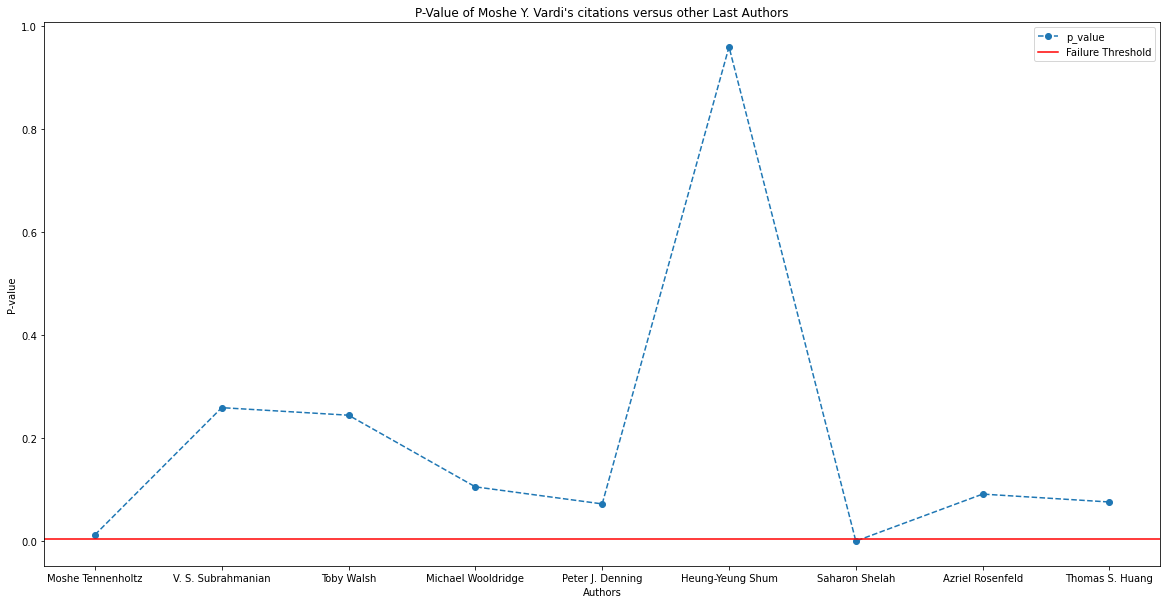

In [1017]:
# plot_multi_pval(last_author, 'last_author', 'n_citation', last_keys, 'Last Authors', marker = 'o', linestyle = 'dashed')
plot_pval(last_author, 'last_author', 'n_citation', last_keys, 0, 'Last Authors', label = 'p_value', marker = 'o', linestyle = 'dashed')
plt.savefig('img/last_author_pval.png')

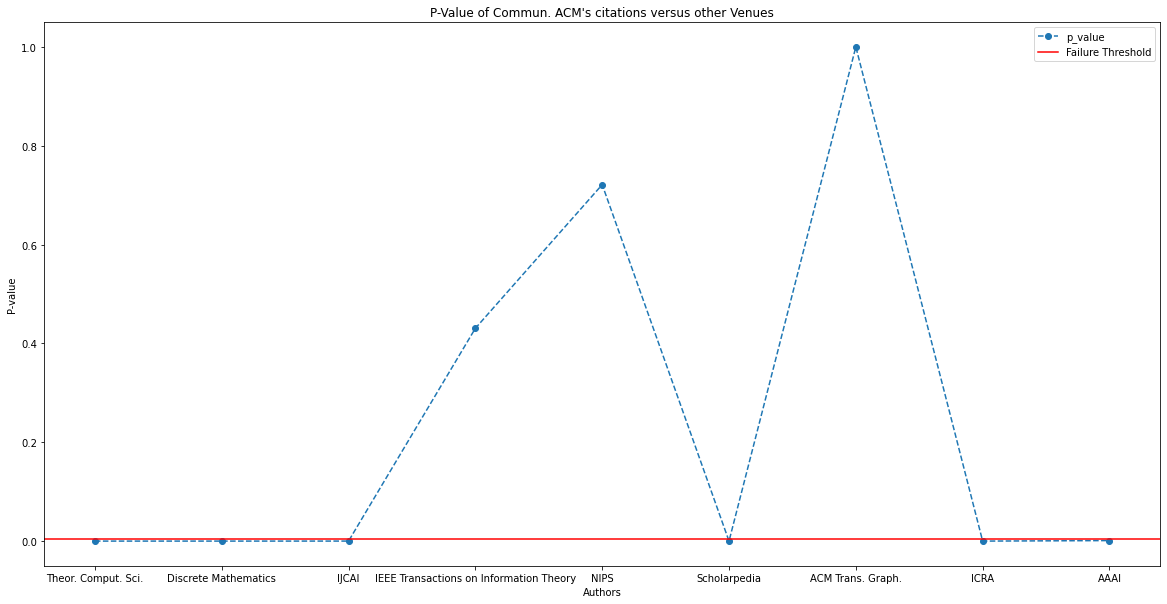

In [1012]:
plot_pval(venue, 'venue_name', 'n_citation', venue_keys, 0, 'Venues', label = 'p_value', marker = 'o', linestyle = 'dashed')
plt.savefig('img/venue_pval.png')

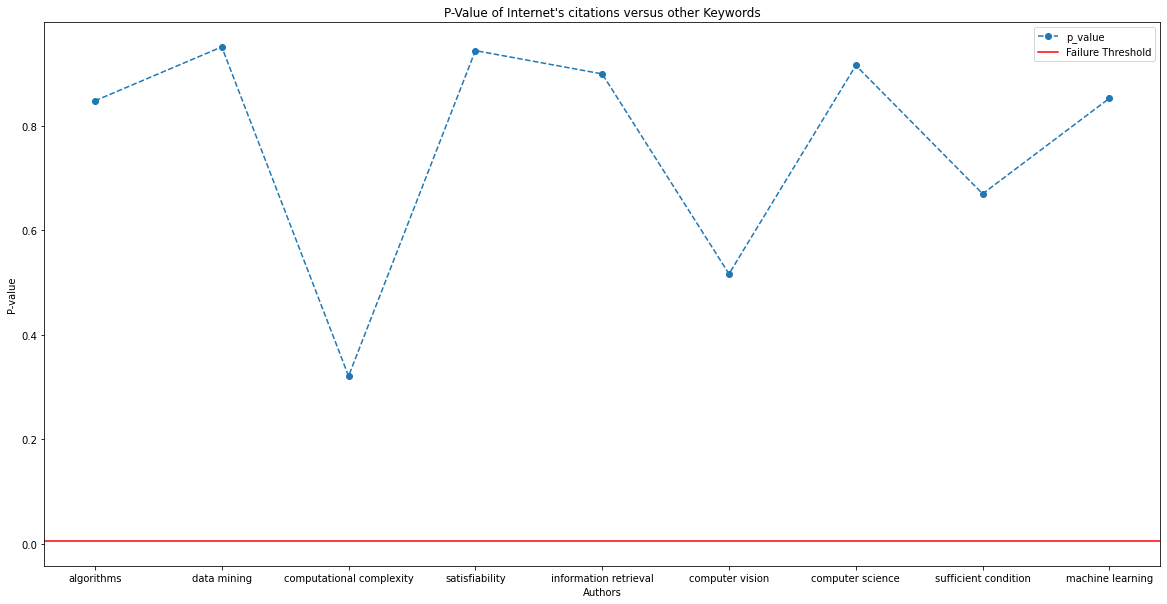

In [1013]:
plot_pval(keywords, 'first_keyword', 'n_citation', keyword_keys, 0, 'Keywords', label = 'p_value', marker = 'o', linestyle = 'dashed')
plt.savefig('img/keywords_pval.png')

## Insights

1. All keywords fail to reject the null hypothesis. We can conclude there is no stat. sig. difference in keywords
2. The last author failed to reject the null hypothesis in most cases except for 1. This means the most profilic last authors have no stat. sign. impact on # of citations other than vs Saharon.
3. The most prolific venue did have multiple significant difference where it is greater. Only IEEE, NIPS and ACM tran have similar penetration.

Assuming number of citations indicates it penetration in the scientific community

## Diving Deeper

### We would like to see if there is truly a difference between the most prolific Author and prolific Venue.

#### Null Hypothesis: There is no difference between all the most prolific Author and Venue

#### Alternate Hypothesis: There is an intragroup difference between the Author and Venue
##### Alpha is 0.05

In [1027]:
top_author_mixed = sum(focused_journal[focused_journal['last_author'] == last_keys[0]]['venue_name'] == venue_keys[0])
total_top_author = sum(focused_journal['last_author'] == last_keys[0])

print(f'''Of {last_keys[0]}\'s publications, {top_author_mixed} out of {total_top_author} have been published in {venue_keys[0]}.
      All the confounding publications will be removed and verified independently''')

cleaned_author = focused_journal[(focused_journal['last_author'] == last_keys[0]) & (focused_journal['venue_name'] != venue_keys[0])]
cleaned_venue = focused_journal[(focused_journal['last_author'] != last_keys[0]) & (focused_journal['venue_name'] == venue_keys[0])]

Of Moshe Y. Vardi's publications, 3 out of 27 have been published in Commun. ACM.
      All the confounding publications will be removed and verified independently


There IS NOT a statistically significant difference between the Author and Venue


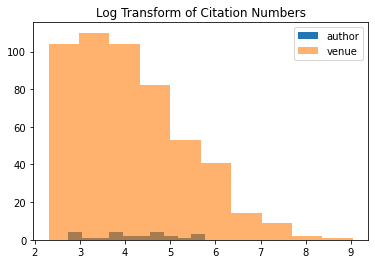

In [1044]:
diff, p_val = stats.ttest_ind(cleaned_author['n_citation'], cleaned_venue['n_citation'], equal_var=False)

fig, ax = plt.subplots()
ax.hist(np.log(cleaned_author['n_citation']), align = 'left', alpha = 1, label = 'author')
ax.hist(np.log(cleaned_venue['n_citation']), alpha = 0.6,  label = 'venue')
ax.set_title('Log Transform of Citation Numbers')
ax.legend()

if p_val < 0.05:
    print("There IS a statistically significant difference between the Author and Venue")
else:
    print("There IS NOT a statistically significant difference between the Author and Venue")

(1960.0, 2020.0)

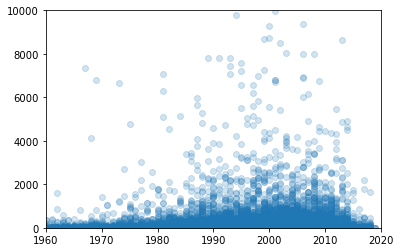

In [10]:
plt.scatter(filter_journal['year'], filter_journal['n_citation'], alpha = 0.2)
plt.ylim(0, 10000)
plt.xlim(1960, 2020)

(array([4.6094e+04, 1.0055e+04, 4.6270e+03, 2.7860e+03, 1.7620e+03,
        1.2830e+03, 9.0300e+02, 6.6800e+02, 5.7200e+02, 4.7900e+02,
        3.7900e+02, 3.1400e+02, 2.4400e+02, 2.2000e+02, 2.0700e+02,
        1.7500e+02, 1.5800e+02, 1.3800e+02, 1.1800e+02, 9.9000e+01,
        1.0100e+02, 8.6000e+01, 8.4000e+01, 7.9000e+01, 6.6000e+01,
        6.5000e+01, 4.4000e+01, 5.0000e+01, 5.4000e+01, 3.8000e+01,
        3.2000e+01, 4.2000e+01, 3.9000e+01, 3.4000e+01, 2.7000e+01,
        2.5000e+01, 2.7000e+01, 1.8000e+01, 3.3000e+01, 1.8000e+01,
        1.9000e+01, 1.9000e+01, 2.7000e+01, 2.9000e+01, 2.2000e+01,
        1.8000e+01, 1.6000e+01, 1.4000e+01, 9.0000e+00, 1.1000e+01]),
 array([  1.  ,  20.96,  40.92,  60.88,  80.84, 100.8 , 120.76, 140.72,
        160.68, 180.64, 200.6 , 220.56, 240.52, 260.48, 280.44, 300.4 ,
        320.36, 340.32, 360.28, 380.24, 400.2 , 420.16, 440.12, 460.08,
        480.04, 500.  , 519.96, 539.92, 559.88, 579.84, 599.8 , 619.76,
        639.72, 659.68, 679.64

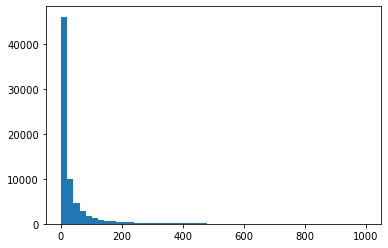

In [11]:
filter_journal_citations = filter_journal[filter_journal['n_citation'] > 0]
sub_1000 = filter_journal_citations[filter_journal_citations['n_citation'] < 1000]
plt.hist(sub_1000['n_citation'], bins = 50)

In [15]:
display(len(sub_1000[sub_1000['keywords'].str.len() > 0]))
display(len(count_idx_new.keys()))

56326

38510

In [16]:
count_idx_new.most_common(100)

[('Internet', 145),
 ('data mining', 111),
 ('computational complexity', 89),
 ('algorithms', 85),
 ('satisfiability', 68),
 ('null', 67),
 ('neural network', 63),
 ('information retrieval', 59),
 ('first page', 54),
 ('sufficient condition', 53),
 ('indexation', 53),
 ('computer science', 53),
 ('feature extraction', 48),
 ('software system', 48),
 ('computer vision', 48),
 ('optimisation', 47),
 ('Markov processes', 46),
 ('computational geometry', 45),
 ('design', 44),
 ('real time', 44),
 ('CMOS integrated circuits', 44),
 ('internet', 41),
 ('social network', 40),
 ('machine learning', 40),
 ('main result', 39),
 ('business process', 39),
 ('speech recognition', 39),
 ('artificial intelligence', 38),
 ('software engineering', 38),
 ('pattern recognition', 38),
 ('parallel algorithm', 37),
 ('feature selection', 37),
 ('VLSI', 36),
 ('ad hoc networks', 36),
 ('general', 35),
 ('Computational Mathematic', 35),
 ('programming language', 35),
 ('bioinformatics', 35),
 ('Information Sy

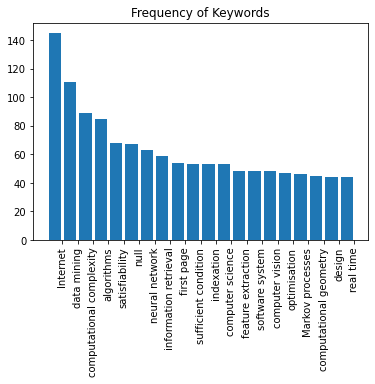

In [19]:
import numpy as np
labels, values = zip(*count_idx_new.most_common(20))
indexes = np.arange(len(labels))
plt.bar(indexes, values)
plt.title("Frequency of Keywords")
plt.xticks(indexes + 0.5, labels, rotation = 90)
plt.show()

In [507]:
type(Counter())

collections.Counter

In [50]:
idx = 0
# for i in filter_journal_citations['authors']:
#     if idx > 10:
#         break
#     len(i)
type(filter_journal_citations)

pandas.core.frame.DataFrame

In [465]:
first_name_all, errors_first_name_all = most_common_counter(filter_journal['authors'], key = 'name', last = False)
# results.most_common(5)
# errors.most_common(5)

100%|██████████| 99967/99967 [00:00<00:00, 570245.73it/s]


In [468]:
first_name_all.most_common(20)

[('Karl Rihaczek', 122),
 ('Dirk Fox', 62),
 ('Alois Potton', 55),
 ('Peter G. Neumann', 51),
 ('Johann Bizer', 50),
 ('Edmond Bianco', 47),
 ('&NA;', 42),
 ('Peter J. Denning', 39),
 ('Richard Mateosian', 39),
 ('David Alan Grier', 38),
 ('Gunter Dueck', 35),
 ('Noga Alon', 34),
 ('Nachum Dershowitz', 32),
 ('Burt Kaliski', 28),
 ('Peter Mertens', 28),
 ('Friedrich L. Bauer', 28),
 ('Not Available Not Available', 27),
 ('Ramesh Jain', 26),
 ('George Neville-Neil', 26),
 ('Gary Singh', 26)]

In [134]:
first_name_all.most_common(20)

[('Karl Rihaczek', 122),
 ('Dirk Fox', 62),
 ('Alois Potton', 55),
 ('Peter G. Neumann', 51),
 ('Johann Bizer', 50),
 ('Edmond Bianco', 47),
 ('&NA;', 42),
 ('Peter J. Denning', 39),
 ('Richard Mateosian', 39),
 ('David Alan Grier', 38),
 ('Gunter Dueck', 35),
 ('Noga Alon', 34),
 ('Nachum Dershowitz', 32),
 ('Burt Kaliski', 28),
 ('Peter Mertens', 28),
 ('Friedrich L. Bauer', 28),
 ('Not Available Not Available', 27),
 ('Ramesh Jain', 26),
 ('George Neville-Neil', 26),
 ('Gary Singh', 26)]

In [135]:
last_name_all, errors_last_name_all = most_common_counter(filter_journal['authors'], dict_ = True, key = 'name', last = True)
last_name_all.most_common(20)


100%|██████████| 99967/99967 [00:00<00:00, 593481.05it/s]


[('Karl Rihaczek', 121),
 ('Dirk Fox', 64),
 ('Alois Potton', 55),
 ('Johann Bizer', 50),
 ('Peter G. Neumann', 49),
 ('Edmond Bianco', 47),
 ('&NA;', 41),
 ('Moshe Y. Vardi', 40),
 ('Richard Mateosian', 39),
 ('Gunter Dueck', 35),
 ('Ramesh Jain', 35),
 ('Peter J. Denning', 33),
 ('David Alan Grier', 30),
 ('Peter Mertens', 29),
 ('Burt Kaliski', 28),
 ('Not Available Not Available', 27),
 ('Friedrich L. Bauer', 27),
 ('Saharon Shelah', 27),
 ('George Neville-Neil', 27),
 ('Bertrand Meyer', 26)]

In [132]:
last_name_cit, errors_last_name_xit = most_common_counter(filter_journal_citations['authors'], dict_ = True, key = 'name', last = True)
last_name_cit.most_common(10)

100%|██████████| 73044/73044 [00:00<00:00, 610658.80it/s]


[('Moshe Y. Vardi', 37),
 ('Peter G. Neumann', 34),
 ('Ramesh Jain', 28),
 ('Peter J. Denning', 27),
 ('Moshe Tennenholtz', 25),
 ('Derick Wood', 24),
 ('V. S. Subrahmanian', 24),
 ('Saharon Shelah', 23),
 ('Azriel Rosenfeld', 22),
 ('Toby Walsh', 22)]

In [133]:
first_name_cit, errors_first_name_xit = most_common_counter(filter_journal_citations['authors'], dict_ = True, key = 'name', last = False)
first_name_cit.most_common(10)

100%|██████████| 73044/73044 [00:00<00:00, 633678.01it/s]


[('Peter G. Neumann', 36),
 ('Peter J. Denning', 33),
 ('Noga Alon', 32),
 ('Nachum Dershowitz', 29),
 ('Prosenjit Bose', 21),
 ('Luca Cardelli', 21),
 ('Ramesh Jain', 18),
 ('Dirk Fox', 17),
 ('Donald E. Knuth', 17),
 ('Béla Bollobás', 17)]

In [463]:
filter_journal.iloc[7390].venue#[['venue','venue_name']]

{'_id': '53a731f120f7420be8d6d307', 'raw': 'Elektronische Rechenanlagen'}

In [203]:
temp = filter_journal.head(1000)
temp.loc[2, 'authors']

[{'_id': '53f45728dabfaec09f209538', 'name': 'Peijuan Wang'},
 {'_id': '5601754345cedb3395e59457', 'name': 'Jiahua Zhang'},
 {'_id': '53f38438dabfae4b34a08928', 'name': 'Donghui Xie'},
 {'_id': '5601754345cedb3395e5945a', 'name': 'Yanyan Xu'},
 {'_id': '53f43d25dabfaeecd6995149', 'name': 'Yun Xu'}]

In [393]:
filter_journal[['authors', 'first_author', 'last_author']].tail(5)

,authors,first_author,last_author
99996,"[{'_id': '53f4cfe1dabfaeedd377d604', 'name': '...",Andrea Mannini,Angelo M. Sabatini
99997,"[{'_id': '53f4337fdabfaedf435622c3', 'name': '...",Junxia Gu,Youshou Wu
99998,"[{'_id': '53f45495dabfaee1c0b265ce', 'name': '...",J. Sznitman,T. Rösgen
99999,"[{'_id': '53f46490dabfaeee22a4cc1a', 'name': '...",Ulrike Meier,Rudolf Eigenmann
100000,"[{'gid': '5b86b160e1cd8e14a325b465', '_id': '5...",Darin Nelson,S. Muthukrishnan


In [394]:
filter_journal.loc[100000]['authors'][-1],  filter_journal.loc[100000].last_author

({'_id': '53f43211dabfaeb2ac02596f',
  'name': 'S. Muthukrishnan',
  'org': 'AT&T Labs -- Research, 180 Park Avenue., Florham Park, NJ',
  'gid': '5b868e2be1cd8e14a33dc5d3',
  'orgid': '5f71b34b1c455f439fe41dca'},
 'S. Muthukrishnan')

In [395]:
filter_journal.keys()

Index(['_id', 'title', 'authors', 'venue', 'year', 'keywords', 'n_citation',
       'page_start', 'lang', 'volume', 'issue', 'doi', 'url', 'abstract',
       'first_author', 'last_author'],
      dtype='object')

In [503]:
pd.options.display.width = 0
temp, errors = most_common_counter(filter_journal['venue'], 'raw')

100%|██████████| 99967/99967 [00:00<00:00, 419526.92it/s]


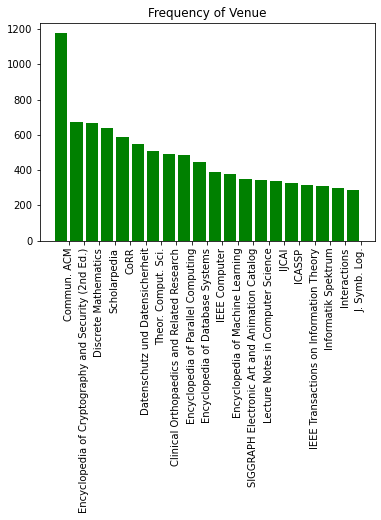

In [528]:
plot_counters(temp, title = "Frequency of Venue", color = 'green')

100%|██████████| 99967/99967 [00:00<00:00, 485850.04it/s]


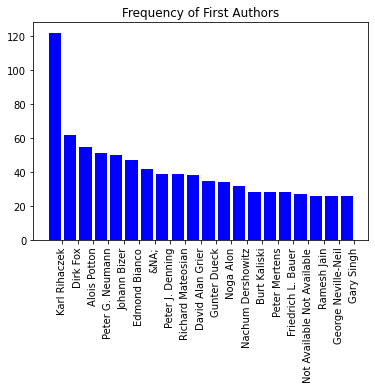

In [529]:
temp, errors = most_common_counter(filter_journal['authors'], 'name')
plot_counters(temp, title = 'Frequency of First Authors', color = 'blue')

100%|██████████| 99967/99967 [00:00<00:00, 605197.01it/s]


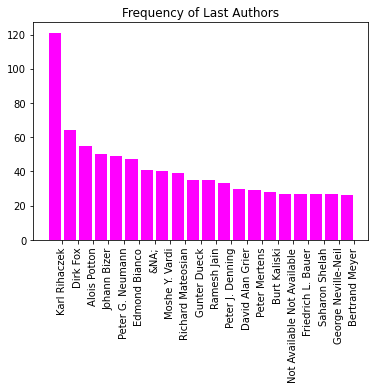

In [530]:
temp, errors = most_common_counter(filter_journal['authors'], 'name', last = True)
plot_counters(temp, title = 'Frequency of Last Authors', color = 'magenta')

In [532]:
filter_journal.describe()

,year,n_citation,n_keywords,abstract_length,n_authors,n_url
count,99967.000000,98119.000000,99915.000000,92222.000000,98695.000000,96786.000000
mean,2002.837276,50.421763,6.611940,570.471146,2.372481,3.073885
std,10.093509,516.017539,8.508191,671.517655,1.895947,35.641955
min,1874.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1998.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,2006.000000,5.000000,4.000000,527.000000,2.000000,2.000000
75%,2010.000000,24.000000,11.000000,917.000000,3.000000,3.000000
max,2019.000000,60891.000000,794.000000,63985.000000,104.000000,5736.000000


In [541]:
populated_journal = filter_journal[filter_journal['n_citation'] > 24].groupby('year').filter(lambda x: len(x) > 10)

In [542]:
plt.scatter(populated_journal['year'], populated_journal['n_citation'])

,_id,title,authors,venue,year,keywords,n_citation,page_start,lang,volume,...,doi,url,abstract,first_author,last_author,venue_name,n_keywords,abstract_length,n_authors,n_url
4,53e99784b7602d9701f3e15d,Timing yield estimation using statistical stat...,"[{'_id': '53f43b03dabfaedce555bf2a', 'name': '...","{'_id': '53a72e2020f7420be8c80142', 'name_d': ...",2005.0,"[sequential circuits, statistical distribution...",28.0,2461,en,,...,10.1109/ISCAS.2005.1465124,"[http://dx.doi.org/10.1109/ISCAS.2005.1465124,...",As process variations become a significant pro...,Min Pan,Hai Zhou,ISCAS (3),33.0,1106.0,3.0,2.0
12,53e99784b7602d9701f3eaf6,1,"[{'_id': '560175b545cedb3395e59d80', 'name': '...","{'_id': '5550378c7cea80f95418e530', 'raw': 'AI...",2013.0,"[existing platform, software agent, BDI model,...",39.0,1186,en,,...,10.1109/WAINA.2013.48,[http://doi.ieeecomputersociety.org/10.1109/WA...,There is a growing interest in the potential o...,C. Evans,S. Abu Rmeileh,AINA Workshops,10.0,1649.0,2.0,1.0
20,53e99784b7602d9701f3f8c1,Foreword,"[{'email': 'harimsri@math.uvic.ca', 'gid': '5b...","{'_id': '53a7314420f7420be8d31c79', 'raw': 'IE...",1966.0,"[Particle Image Velocimetry, Particle Image Ve...",93.0,303,en,111,...,10.1016/S0002-9610(66)80001-6,[http://dx.doi.org/10.1016/S0002-9610(66)80001...,Presents the welcome message from the conferen...,Hiromasa Habuchi,NaN,IEICE Transactions,5.0,61.0,3.0,165.0
24,53e99784b7602d9701f3f411,Using XML to Integrate Existing Software Syste...,"[{'_id': '548a2e3ddabfae9b40134fbc', 'name': '...","{'_id': '53a72e9920f7420be8c93fac', 'name_d': ...",2002.0,"[Internet, hypermedia markup languages, inform...",28.0,167,en,,...,10.1109/CMPSAC.2002.1044548,[http://dx.doi.org/10.1109/CMPSAC.2002.1044548...,The eXtensible Markup Language 驴 XML 驴 is not ...,Harry M. Sneed,Harry M. Sneed,COMPSAC,19.0,475.0,1.0,3.0
31,53e99784b7602d9701f3f92a,Foreword.,[{'name': 'Taleisnik Julio'}],"{'_id': '53a7314420f7420be8d31c79', 'raw': 'IE...",2012.0,"[Support Vector Regression, Load Forecast, Gra...",48.0,3,en,1,...,10.1055/s-0032-1318521,"[http://dx.doi.org/10.1055/s-0032-1318521, htt...",No abstract is available.,Taleisnik Julio,Taleisnik Julio,IEICE Transactions,5.0,25.0,1.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99976,53e998efb7602d9702129bf2,A global sampling method for alpha matting,"[{'_id': '53f431badabfaee02ac9803b', 'name': '...","{'_id': '53a7256420f7420be8b4e0aa', 'name_d': ...",2011.0,"[quantitatively high-quality matting result, h...",256.0,2049,en,,...,10.1109/CVPR.2011.5995495,"[http://dx.doi.org/10.1109/CVPR.2011.5995495, ...",Alpha matting refers to the problem of softly ...,Kaiming He,Jian Sun,CVPR,28.0,1090.0,5.0,2.0
99981,53e998efb7602d9702129de4,The Power of Strong Fourier Sampling: Quantum ...,"[{'_id': '53f46ed8dabfaee02adb632a', 'name': '...","{'_id': '555036f27cea80f95416865a', 'type': 0,...",2007.0,"[affine groups, strong standard method, quantu...",38.0,938,en,37,...,10.1137/S0097539705447177,"[http://dx.doi.org/10.1137/S0097539705447177, ...","Many quantum algorithms, including Shor's cele...",Cristopher Moore,Leonard J. Schulman,SIAM J. Comput.,21.0,2336.0,4.0,3.0
99982,53e998efb7602d9702129de7,Multiscale Modeling and Simulation of Worm Eff...,"[{'gid': '5b86a5afe1cd8e14a3d88b5e', '_id': '5...","{'_id': '53a729ec20f7420be8beacc5', 'name_d': ...",2003.0,"[multiscale modeling, simulation model, intern...",38.0,1,en,,...,10.1007/978-3-540-45232-4_1,[http://dx.doi.org/10.1007/978-3-540-45232-4_1],An unexpected consequence of recent worm attac...,David M. Nicol,Jason Liu,Computer Performance Evaluation (Tools),3.0,664.0,3.0,1.0
99990,53e998efb7602d9702129e15,Metadata-based image watermarking for copyrigh...,"[{'_id': '53f44365dabfaeee229ec3b8', 'name': '...",{'sid': 'simulation-modelling-practice-and-the...,2010.0,"[Watermarking, Metadata, Digital rights manage...",63.0,436,en,18,...,10.1016/j.simpat.2009.09.004,[http://dx.doi.org/10.1016/j.simpat.2009.09

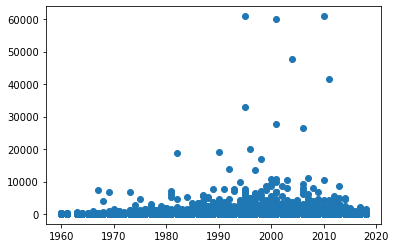

In [543]:
plt.scatter(populated_journal['year'], populated_journal['n_citation'])

In [587]:
keys, values = zip(*temp.most_common(20))

In [552]:
last_author = populated_journal[['last_author','n_citation', 'n_keywords','abstract_length','n_authors','n_url']].groupby('last_author')

In [590]:
last_author = populated_journal[populated_journal['last_author'].isin(keys)]

In [616]:
pd.options.display.width = 0
test = populated_journal.groupby('last_author')[['n_authors', 'n_citation','n_keywords', 'n_url']].agg(['mean', 'count', 'std'])

In [631]:
test = test[test['n_authors']['mean'] > 1]

In [639]:
test.n_citation.sort_values(by = 'mean')

,mean,count,std
last_author,,,
Shey-Shi Lu,25.0,1,NaN
U. Singh,25.0,1,NaN
Anshul Sawant,25.0,1,NaN
Markus W. Schranz,25.0,1,NaN
Yong Choi,25.0,1,NaN
...,...,...,...
Brian G. Schunck,13949.0,1,NaN
Charles R. Johnson,19081.0,1,NaN
David G. Lowe,23965.0,2,33775.66251


In [642]:
populated_journal

,_id,title,authors,venue,year,keywords,n_citation,page_start,lang,volume,...,doi,url,abstract,first_author,last_author,venue_name,n_keywords,abstract_length,n_authors,n_url
4,53e99784b7602d9701f3e15d,Timing yield estimation using statistical stat...,"[{'_id': '53f43b03dabfaedce555bf2a', 'name': '...","{'_id': '53a72e2020f7420be8c80142', 'name_d': ...",2005.0,"[sequential circuits, statistical distribution...",28.0,2461,en,,...,10.1109/ISCAS.2005.1465124,"[http://dx.doi.org/10.1109/ISCAS.2005.1465124,...",As process variations become a significant pro...,Min Pan,Hai Zhou,ISCAS (3),33.0,1106.0,3.0,2.0
12,53e99784b7602d9701f3eaf6,1,"[{'_id': '560175b545cedb3395e59d80', 'name': '...","{'_id': '5550378c7cea80f95418e530', 'raw': 'AI...",2013.0,"[existing platform, software agent, BDI model,...",39.0,1186,en,,...,10.1109/WAINA.2013.48,[http://doi.ieeecomputersociety.org/10.1109/WA...,There is a growing interest in the potential o...,C. Evans,S. Abu Rmeileh,AINA Workshops,10.0,1649.0,2.0,1.0
20,53e99784b7602d9701f3f8c1,Foreword,"[{'email': 'harimsri@math.uvic.ca', 'gid': '5b...","{'_id': '53a7314420f7420be8d31c79', 'raw': 'IE...",1966.0,"[Particle Image Velocimetry, Particle Image Ve...",93.0,303,en,111,...,10.1016/S0002-9610(66)80001-6,[http://dx.doi.org/10.1016/S0002-9610(66)80001...,Presents the welcome message from the conferen...,Hiromasa Habuchi,NaN,IEICE Transactions,5.0,61.0,3.0,165.0
24,53e99784b7602d9701f3f411,Using XML to Integrate Existing Software Syste...,"[{'_id': '548a2e3ddabfae9b40134fbc', 'name': '...","{'_id': '53a72e9920f7420be8c93fac', 'name_d': ...",2002.0,"[Internet, hypermedia markup languages, inform...",28.0,167,en,,...,10.1109/CMPSAC.2002.1044548,[http://dx.doi.org/10.1109/CMPSAC.2002.1044548...,The eXtensible Markup Language 驴 XML 驴 is not ...,Harry M. Sneed,Harry M. Sneed,COMPSAC,19.0,475.0,1.0,3.0
31,53e99784b7602d9701f3f92a,Foreword.,[{'name': 'Taleisnik Julio'}],"{'_id': '53a7314420f7420be8d31c79', 'raw': 'IE...",2012.0,"[Support Vector Regression, Load Forecast, Gra...",48.0,3,en,1,...,10.1055/s-0032-1318521,"[http://dx.doi.org/10.1055/s-0032-1318521, htt...",No abstract is available.,Taleisnik Julio,Taleisnik Julio,IEICE Transactions,5.0,25.0,1.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99976,53e998efb7602d9702129bf2,A global sampling method for alpha matting,"[{'_id': '53f431badabfaee02ac9803b', 'name': '...","{'_id': '53a7256420f7420be8b4e0aa', 'name_d': ...",2011.0,"[quantitatively high-quality matting result, h...",256.0,2049,en,,...,10.1109/CVPR.2011.5995495,"[http://dx.doi.org/10.1109/CVPR.2011.5995495, ...",Alpha matting refers to the problem of softly ...,Kaiming He,Jian Sun,CVPR,28.0,1090.0,5.0,2.0
99981,53e998efb7602d9702129de4,The Power of Strong Fourier Sampling: Quantum ...,"[{'_id': '53f46ed8dabfaee02adb632a', 'name': '...","{'_id': '555036f27cea80f95416865a', 'type': 0,...",2007.0,"[affine groups, strong standard method, quantu...",38.0,938,en,37,...,10.1137/S0097539705447177,"[http://dx.doi.org/10.1137/S0097539705447177, ...","Many quantum algorithms, including Shor's cele...",Cristopher Moore,Leonard J. Schulman,SIAM J. Comput.,21.0,2336.0,4.0,3.0
99982,53e998efb7602d9702129de7,Multiscale Modeling and Simulation of Worm Eff...,"[{'gid': '5b86a5afe1cd8e14a3d88b5e', '_id': '5...","{'_id': '53a729ec20f7420be8beacc5', 'name_d': ...",2003.0,"[multiscale modeling, simulation model, intern...",38.0,1,en,,...,10.1007/978-3-540-45232-4_1,[http://dx.doi.org/10.1007/978-3-540-45232-4_1],An unexpected consequence of recent worm attac...,David M. Nicol,Jason Liu,Computer Performance Evaluation (Tools),3.0,664.0,3.0,1.0
99990,53e998efb7602d9702129e15,Metadata-based image watermarking for copyrigh...,"[{'_id': '53f44365dabfaeee229ec3b8', 'name': '...",{'sid': 'simulation-modelling-practice-and-the...,2010.0,"[Watermarking, Metadata, Digital rights manage...",63.0,436,en,18,...,10.1016/j.simpat.2009.09.004,[http://dx.doi.org/10.1016/j.simpat.2009.09